In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import cmap
from Bio import PDB
from Bio.PDB.DSSP import DSSP
import performance
import biotite.application.dssp as dssp

In [2]:
trrosetta='/home/fapatalano/Desktop/tesi/distpred'
relax_parameter=[0,1,2]

In [3]:
def get_ss_structure(pdbfile,pdb_code):
    ss_structure = []
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb_code, pdbfile)
    model = structure[0]
    dssp = DSSP(model, pdbfile)
    a_key = list(dssp.keys())
    for a in a_key:
        if a[0] == 'A':
           ss_structure += dssp[a][2]
    # df_ss= pd.DataFrame.from_dict(lcDict)

    return ss_structure

In [4]:
def calc_ppv(pred_inter_d,true_inter_d,n=0):

    TP=0
    FP=0
    TN=0
    FN=0
    padded_true_interd = np.pad(true_inter_d,((n,n),(n,n)),'constant',constant_values=np.nan)
    predicted_contact = np.where(~np.isnan(pred_inter_d) & (pred_inter_d!=20))
    predicted_non_contact = np.where(np.isnan(pred_inter_d) | (pred_inter_d==20) )
    for pred_cont_coord in zip(predicted_contact[0],predicted_contact[1]) :
        if not np.isnan(padded_true_interd[pred_cont_coord]): TP += 1
        elif np.isnan(padded_true_interd[pred_cont_coord]): FP += 1
        else: print(true_inter_d[pred_cont_coord],padded_true_interd[pred_cont_coord])
    for pred_non_cont_coord in zip(predicted_non_contact[0],predicted_non_contact[1]) :
        if np.isnan(padded_true_interd[pred_non_cont_coord]) : TN += 1
        elif not np.isnan(padded_true_interd[pred_non_cont_coord]): FN += 1
        else: print(true_inter_d[pred_non_cont_coord],padded_true_interd[pred_non_cont_coord])
    ppv= TP/(TP+FP)
    return TP,FP,TN,FN,ppv

In [5]:
def disteval_main(trrosetta, relax_parameter):

    tot_dict = {}
    tot_true_intra_distances = []
    tot_true_inter_distances = []
    tot_pred_inter_distances = []
    tot_pred_intra_distances = []
    ss_structure= []
    perf=[]


    for entry in os.scandir(trrosetta):
        if entry.path.endswith(".npz") and entry.is_file():
            performance_dict = {}
            # Prepare the monomer structure and the prediction

            pdb_code = entry.name.split('-')[0][:-4].upper()
            print('\nStructure',pdb_code)
            pdbfile = f'/home/fapatalano/Desktop/tesi/dataset/pdb_file/{pdb_code}.pdb'
            ss = get_ss_structure(pdbfile,pdb_code)
            ss_structure += ss
            residues = cmap.get_pdb_coord(pdbfile, pdb_code)
            pdb_cmap = cmap.pdb2dmap(residues)
            L = pdb_cmap.shape[0]//2
            tot_true_intra_distances += pdb_cmap[:L,:L].flatten().tolist()
            # tot_true_inter_distances += pdb_cmap[:L,L:].flatten().tolist()

            print('\nTrue dmap: ', pdb_cmap.shape)
            true_intrachain_contact = cmap.get_true_intrachain_dist(pdb_cmap,residues)

            print('\nLoad the input trRosetta prediction..')
            trrosetta_map = np.load(entry)
            D = cmap.trrosetta2maps(trrosetta_map)
            tot_pred_intra_distances += D.flatten().tolist()
            print('TrRosetta map: ', D.shape)

            interactions_between_chains = cmap.get_interacting_residues(residues, r_cutoff=6)
            true_interchain_contact = cmap.get_true_inter_distances(interactions_between_chains, residues)
            tot_true_inter_distances += true_interchain_contact.flatten().tolist()

            print('Total number of interchain contacts',len(np.where(~np.isnan(true_interchain_contact))[0]))

            # Filter short range contacts and true intrachain contacts
            filtered_dist = cmap.filter_contact(D,true_intrachain_contact)
            print(filtered_dist.shape)
            tot_pred_inter_distances += filtered_dist.flatten().tolist()
            TP,FP,TN,FN,ppv,tot= performance.relaxation(true_interchain_contact,filtered_dist,0)
            perf += tot
            print(TP,FP,TN,FN)
            print('PPV',ppv)
            # relax_removal_map_0 =  cmap.relax_removal(filtered_dist, true_intrachain_contact, 0)
            # relax_removal_map_1 =  cmap.relax_removal(filtered_dist, true_intrachain_contact, 1)
            # relax_removal_map_2 =  cmap.relax_removal(filtered_dist, true_intrachain_contact, 2)

            # Relax removal
            # for n in relax_parameter:
            #     TP,FP,TN,FN,PPV= performance.relaxation(true_interchain_contact,relax_removal_map_0,n)
            #     print(f'{n}-0',TP,FP,TN,FN,PPV)
            #     TP,FP,TN,FN,PPV= performance.relaxation(true_interchain_contact,relax_removal_map_1,n)
            #     print(f'{n}-1',TP,FP,TN,FN,PPV)
            #     TP,FP,TN,FN,PPV= performance.relaxation(true_interchain_contact,relax_removal_map_2,n)
            #     print(f'{n}-2',TP,FP,TN,FN,PPV)
            # #     performance_dict[n] = [tp,tn,fp,fn]
            #     # print(f'TP={tp}\nTN={tn}\nFP={fp}\nFN={fn}')
    return  tot_true_intra_distances, tot_true_inter_distances,tot_pred_inter_distances,tot_pred_intra_distances,ss_structure,perf



# print(f'Number of total interchain contacts:{tot_intercontact}')
# print(f'Tot:{tot_dict}')
# return tot_dict,intra_distances_map,inter_distances_map,pred_intra_distances_map,pred_inter_distances_map
tot_true_intra_distances, tot_true_inter_distances,tot_pred_inter_distances,tot_pred_intra_distances,ss_structure,perf = disteval_main(trrosetta, relax_parameter)


Structure 2QVH

True dmap:  (618, 618)

Load the input trRosetta prediction..
TrRosetta map:  (309, 309)
Total number of interchain contacts 28
(309, 309)
0 3244 92209 28
PPV 0.0

Structure 5HRA

True dmap:  (466, 466)

Load the input trRosetta prediction..
TrRosetta map:  (233, 233)
Total number of interchain contacts 158
(233, 233)
17 3029 51102 141
PPV 0.005581089954038083

Structure 6CSC

True dmap:  (874, 874)

Load the input trRosetta prediction..
TrRosetta map:  (437, 437)
Total number of interchain contacts 561
(437, 437)
43 4185 186223 518
PPV 0.010170293282876065

Structure 6VD8

True dmap:  (170, 170)

Load the input trRosetta prediction..
TrRosetta map:  (85, 85)
Total number of interchain contacts 61
(85, 85)
7 897 6267 54
PPV 0.007743362831858407

Structure 3FMB

True dmap:  (200, 200)

Load the input trRosetta prediction..
TrRosetta map:  (100, 100)
Total number of interchain contacts 109
(100, 100)
11 1017 8874 98
PPV 0.010700389105058366

Structure 3VVX

True dmap:  (

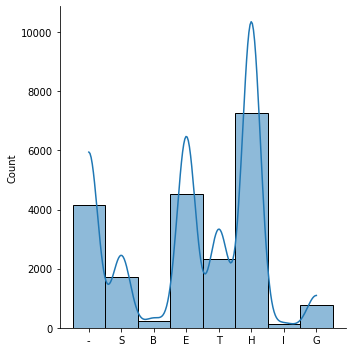

In [6]:
sns.displot(ss_structure,kde=True)

In [7]:
data = {'tot_true_intra_distances': tot_true_intra_distances, 'tot_true_inter_distances': tot_true_inter_distances,'tot_pred_inter_distances':tot_pred_inter_distances,'tot_pred_intra_distances':tot_pred_intra_distances,'label':perf}
df= pd.DataFrame.from_dict(data)
df['label'] = df['label'].replace(['TN'],np.nan)

In [8]:
df_10 = df.sample(frac=0.1, random_state=1)
df_10

,tot_true_intra_distances,tot_true_inter_distances,tot_pred_inter_distances,tot_pred_intra_distances,label
3113281,43.063499,NaN,NaN,20.000000,NaN
137115,15.418843,NaN,NaN,13.271932,NaN
2688147,25.596073,NaN,NaN,20.000000,NaN
5556980,14.669699,NaN,NaN,14.814067,NaN
4984208,26.043604,NaN,NaN,15.267522,NaN
...,...,...,...,...,...
3259796,11.928478,NaN,NaN,15.814324,NaN
5681220,24.680714,NaN,NaN,20.000000,FP
3263692,14.246643,NaN,NaN,14.755022,NaN
865603,13.416173,NaN,NaN,20.000000,NaN


g = sns.jointplot(data=df_10, x='tot_true_intra_distances', y='tot_true_inter_distances',kind="kde")
g.plot_joint(sns.scatterplot,marker="+",s=5,color='darkorange')
plt.savefig('/home/fapatalano/Desktop/tesi/results/images/true_intra_true_inter.pdf')

g = sns.jointplot(data=df_10, x='tot_true_intra_distances', y='tot_pred_intra_distances',kind="kde")
g.plot_joint(sns.scatterplot,marker="+",s=5,color='darkorange')
# plt.savefig('/home/fapatalano/Desktop/tesi/results/images/true_intra_pred_intra.pdf')

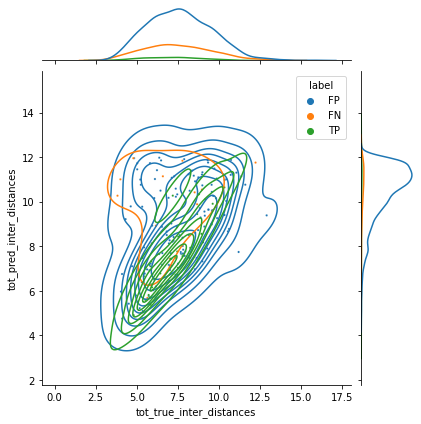

In [9]:
g = sns.jointplot(data=df,x='tot_true_inter_distances', y='tot_pred_inter_distances',kind="kde",hue="label")
g.plot_joint(sns.scatterplot,s=5,hue="label")
plt.savefig('/home/fapatalano/Desktop/tesi/results/images/fig_1.pdf')

In [10]:
_0_4=0
_5_10=0
_11_15=0
_16_19=0
_20=0
nan=0
tot=0
for i in df['tot_pred_inter_distances']:
  tot+=1
  if i ==20: _20 += 1
  elif i<=4: _0_4+= 1
  elif i>4 and i<=10: _5_10+= 1
  elif i>10 and i<=15: _11_15+= 1
  elif i>15 and i<20: _16_19+= 1
  elif np.isnan(i): nan+=1
  else: print(i)
print( _0_4,_5_10,_11_15,_16_19,_20,nan,tot)

print(_0_4+_5_10+_11_15+_16_19+_20+nan)
print(tot)

0 55548 159624 0 0 5928787 6143959
6143959
6143959


In [11]:
print( 100 * float(_0_4)/float(tot))
print( 100 * float(_5_10)/float(tot))
print( 100 * float(_11_15)/float(tot))
print( 100 * float(_16_19)/float(tot))
print( 100 * float(_20)/float(tot))
print( 100 * float(nan)/float(tot))

print(73.36565885286669 + 5.192759261577104)

0.0
0.9041075957700889
2.598064212342563
0.0
0.0
96.49782819188735
78.5584181144438


In [12]:
print(round(78.5584181144438,2))
labels = ['0-4', '5-10', '11-15', '16-19','20']
sizes = [0, 0.9, 10.26, 10.27,78.56]


78.56


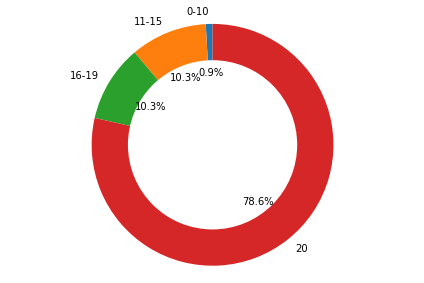

In [13]:
# Pie chart
labels = ['0-10', '11-15', '16-19','20']
sizes = [0.9, 10.26, 10.27,78.56]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()
# plt.savefig('/home/fapatalano/Desktop/tesi/results/images/pieplot.pdf')


distances= {'true_intra':tot_true_intra_distances,'pred_intra':tot_pred_intra_distances,'pred_inter':tot_pred_inter_distances,'true_inter':tot_true_inter_distances}

print(len(distances['true_inter']))
print(len(distances['pred_inter']))
print(len(distances['pred_intra']))
print(len(distances['true_intra']))
df = pd.DataFrame.from_dict(distances)
sns.scatterplot(data=distances, x='true_intra', y='pred_intra')
sns.scatterplot(data=distances, x='true_inter', y='pred_inter')
# plt.savefig('/home/fapatalano/Desktop/tesi/results/images/1a64.pdf')

ax =sns.scatterplot(data=df, x='true_inter', y='pred_inter')
ax.set(xlabel='true distances', ylabel='pred distances', title='Inter-chain distances')
plt.savefig('interdist.pdf')